In [34]:
import sys
import os
possible_paths = [
        '/Users/khang/Desktop/math285j_project/data/drive-download-20250531T145738Z-1-001/CRSP Data Set',
        '/Users/lunjizhu/Desktop/MATH 285J Project Workspace/spectral_clustering_finance/data',
        'F:/spectral_clustering_finance/data/drive-download-20250531T145738Z-1-001/CRSP Data Set',
        '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set'
    ]

path = None
for p in possible_paths:
    if os.path.isdir(p):
        path = p
        print(f"Using data path: {path}")
        break

if path is None:
    print("Error: No valid data path found.")
    sys.exit(1)

Using data path: /Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set


In [35]:
from utils.returns import *
from utils.trader import execute_trading_strategy
from utils.helper import *
from utils.cluster import *
from utils.trader import *

In [36]:
eligible_dates_txt_output = path + '/eligible_dates.txt'
eligible_dates = get_eligible_date_paths_from_file(eligible_dates_txt_output)
print(f"Eligible dates loaded: {eligible_dates}")

Successfully read 5269 paths from /Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/eligible_dates.txt
Eligible dates loaded: ['/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2000/20000103.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2000/20000316.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2000/20000331.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2000/20000414.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2000/20001218.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2001/20010102.csv.gz', '/Users/yifangu/Desktop/MATH 285J/285J Project/spectral_clustering_finance/data/CRSP Data Set/2001/20010103.csv.gz', '/Users/yif

In [37]:
def winsorize(data, lower_pct=0.01, upper_pct=0.99):
    """
    Winsorize a list or array of numbers by replacing values below the lower 
    percentile and above the upper percentile with the respective percentile values.

    Parameters:
        data (list or np.ndarray): The input numeric data.
        lower_pct (float): Lower percentile threshold (e.g., 0.05 for 5%).
        upper_pct (float): Upper percentile threshold (e.g., 0.95 for 95%).

    Returns:
        np.ndarray: Winsorized version of the input data.
    """
    data = np.asarray(data)
    lower_bound = np.percentile(data, lower_pct * 100)
    upper_bound = np.percentile(data, upper_pct * 100)
    
    return np.clip(data, lower_bound, upper_bound)

In [38]:
def clusterize_yes(cl_med: str, num_med: str, R_cov: pd.DataFrame, market_cov, clustering_window=20, default_cluster_num=15):
    R = R_cov.copy()
    market = market_cov.copy()

    # compute the correlation matrix used for clusterization
    residual_returns_matrix = get_market_residual_returns(R, market)
    residual_returns_matrix = residual_returns_matrix.astype(float).T
    
    # """ WINSORIZATION! """
    # for i in range(residual_returns_matrix.shape[0]):
    #     residual_returns_matrix[i, :] = winsorize(residual_returns_matrix[i, :])
    
    corr = compute_correlation_matrix(residual_returns_matrix)

    # choose which clusterization method to use
    if cl_med == 'SPONGE':

        # determine the number of clusters for the SPONGE algorithm
        # 'var' means we use percent of explained variance
        # 'mar-pa' means we use the marchenko-pastur distribution
        if num_med == 'var' or num_med == 'mar-pa':
            RRT_num_clusters = residual_returns_matrix[-clustering_window :, :]
        cov = 1/(clustering_window) * (RRT_num_clusters.T @ RRT_num_clusters)
        if num_med == 'var':
            k = get_num_of_clusters(cov, 0.9)
        if num_med == 'mar-pa':
            num_of_stocks = RRT_num_clusters.shape[1]
            rho = num_of_stocks / clustering_window
            lambda_plus = (1 + np.sqrt(rho)) ** 2
            print(lambda_plus)
            eigs = eigh(cov, eigvals_only=True)
            print(eigs)
            plt.figure(figsize=(6, 4))
            plt.hist(eigs, bins=20, edgecolor='black', alpha=0.7)
            plt.title("Distribution of Eigenvalues")
            plt.xlabel("Eigenvalue")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            k = np.sum(eigs > lambda_plus)
            print(k)
        # 'self' means we pass in # of clusters ourselves
        if num_med == 'self':
            k = default_cluster_num
        # split the correlation matrix into positive and negative parts
        G_plus = np.maximum(corr, 0)
        G_minus = np.maximum(-corr, 0)
        # call the SPONGE algorithm
        c = Cluster((csc_matrix(G_plus), csc_matrix(G_minus)))
        predictions = c.SPONGE(k=k, tau_p=1, tau_n=1, eigens=None, mi=None)
        # append predicted cluster assignments
        R['cluster'] = predictions

    # cluster stocks based on given industry data
    # any stock that does not belong to the given list of stock-industry pairs
    # is clustered into one single, separate cluster
    # if cl_med == 'industry':
    #   ticker_to_cluster = dict(zip(sector['SPY.1'], sector['0']))
    #   R['cluster'] = R['ticker'].map(ticker_to_cluster)
    #   R['cluster'] = pd.to_numeric(R['cluster'], errors='coerce').astype('Int64')
    #   max_cluster = R['cluster'].max()
    #   R['cluster'] = R['cluster'].fillna(max_cluster + 1).astype(int)
    return R

In [48]:
def execute_trading_strategy(win_threshold: float,
                            lookback_window = 60,
                            lookforward_window = 3,
                            w = 5,
                            eligible_dates = None,
                            cl_med = 'SPONGE',
                            num_med = 'var'):
    # record the total number of days
    num_dates = len(eligible_dates)
    # first trading day
    current_date = lookback_window
    # record daily_PnL
    daily_PnL = []

# renew_portfolio criteria
    # trading_period = 0
    # trading_PnL = 0
    # update_portfolio = True

    while current_date + lookforward_window < num_dates:
        start_date = current_date - lookback_window
        # size of R_curr: #stocks x (1 ticker + 63 days)
        # size of market_curr: 63
        R_curr, market_curr = get_sliding_window_data(eligible_dates = eligible_dates,
                                                    lookback_window = lookback_window,
                                                    lookforward_window=lookforward_window,
                                                    start_date = start_date)
        
        """ WINSORIZATION! """
        R_curr_np = R_curr.select_dtypes(include='number').to_numpy()
        for j in range(R_curr_np.shape[1]):
            R_curr_np[:,j] = winsorize(R_curr_np[:,j])
        R_curr.iloc[:, 1:] = R_curr_np
        
        # R_cov is the matrix containing the return in the 60 days lookback window
        R_cov = R_curr.iloc[:, : lookback_window + 1]
        market_cov = market_curr[: lookback_window]
        # clusterize the stocks
        R_cov = clusterize_yes(cl_med, num_med, R_cov, market_cov)
        R_cov = assign_stock_weights(identify_stocks(R_cov))
        # calculate PnLs for the lookforward window
        bet_size = R_cov['notional'].to_numpy()
        lookback = -1 * lookforward_window
        future_return = R_curr.iloc[:, lookback:].to_numpy()
        PnLs = future_return.T @ bet_size
        Cumpnl = np.cumsum(PnLs)

        if np.max(Cumpnl) > win_threshold:
            index = np.argmax(Cumpnl > win_threshold)
            PnLs = PnLs[:index+1]

            daily_PnL += PnLs.tolist()
            current_date += index + 1
        else:
            daily_PnL += PnLs.tolist()
            current_date += lookforward_window
        print(f"Day {current_date+1}: PnL = {PnLs}")
    return daily_PnL

In [ ]:
import time

start_time = time.time()
daily_PnL = execute_trading_strategy(win_threshold=0.05,
                                     lookback_window=60,
                                     lookforward_window=3,
                                     w=5,
                                     eligible_dates=eligible_dates)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Day 64: PnL = [-0.08 -0.08  0.23]
Day 65: PnL = [0.12]
Day 68: PnL = [-0.06 -0.03 -0.02]
Day 71: PnL = [-0.   -0.04  0.02]
Day 72: PnL = [0.09]
Day 73: PnL = [0.06]
Day 74: PnL = [0.18]
Day 77: PnL = [0.03 0.   0.02]
Day 80: PnL = [-0.   -0.03 -0.03]
Day 83: PnL = [-0.05 -0.03 -0.01]
Day 86: PnL = [-0.01 -0.04 -0.05]
Day 89: PnL = [-0.06  0.07  0.11]
Day 91: PnL = [0.04 0.02]
Day 92: PnL = [0.09]
Day 93: PnL = [0.09]
Day 96: PnL = [-0.05 -0.04 -0.04]
Day 99: PnL = [-0.    0.03  0.03]
Day 101: PnL = [0.04 0.08]
Day 104: PnL = [0.01 0.02 0.13]
Day 106: PnL = [0.05 0.03]
Day 109: PnL = [ 0.01 -0.04 -0.09]
Day 110: PnL = [0.06]
Day 113: PnL = [-0.01 -0.07 -0.02]
Day 116: PnL = [-0.05 -0.2   0.11]
Day 118: PnL = [0.01 0.05]
Day 119: PnL = [0.11]
Day 122: PnL = [-0.02  0.02  0.01]
Day 125: PnL = [-0.09 -0.01 -0.09]
Day 128: PnL = [-0.04 -0.07  0.01]
Day 130: PnL = [0.03 0.02]
Day 132: PnL = [-0.03  0.1 ]
Day 133: PnL = [0.06]
Day 134: PnL = [0.06]
Day 137: PnL = [-0.02 -0.02  0.01]
Day 138: 

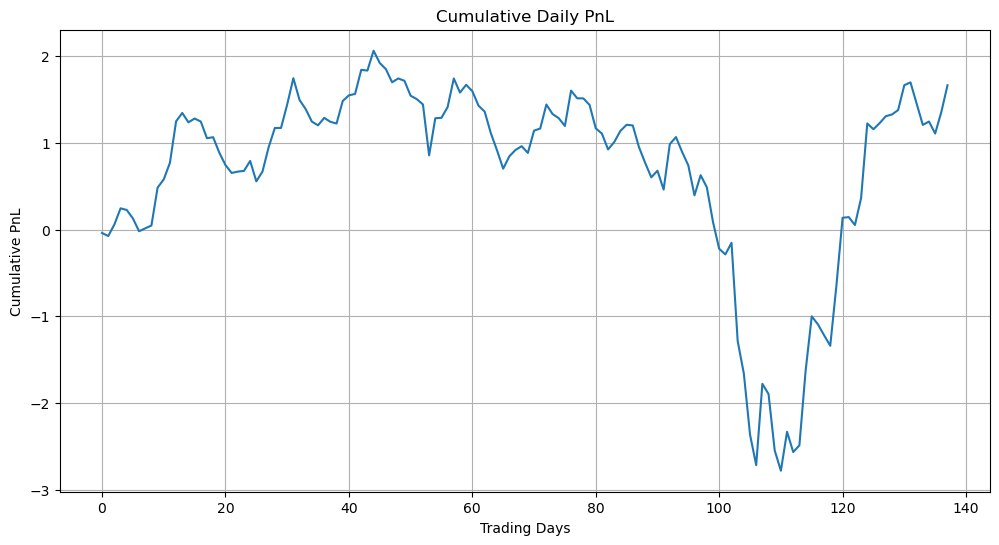

In [10]:
import matplotlib.pyplot as plt
cumulative_pnl = np.cumsum(daily_PnL)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl)
plt.title('Cumulative Daily PnL')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

In [11]:
def calculate_sharpe_ratio(daily_PnL):
    mean = np.mean(daily_PnL)
    stdev = np.std(daily_PnL)
    SR = mean / stdev * np.sqrt(252)
    return SR

In [12]:
print(len(daily_PnL))

138


In [13]:
market_curr = get_sliding_window_data(eligible_dates = eligible_dates,
                                                    lookback_window = 138,
                                                    lookforward_window = 0,
                                                    start_date = 60)[1]

In [17]:
print(market_curr.shape)

(138, 2)


In [18]:
import statsmodels.api as sm
market_curr = sm.add_constant(market_curr)
market_curr = np.array(market_curr, dtype=float)
model = sm.OLS(daily_PnL, market_curr).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     28.11
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           4.52e-07
Time:                        10:37:34   Log-Likelihood:                -7.9970
No. Observations:                 138   AIC:                             19.99
Df Residuals:                     136   BIC:                             25.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.022      0.718      0.4